## ** To be integrated with other notebook?

In [1]:
from allensdk.brain_observatory.drifting_gratings import DriftingGratings
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

manifest_file = '../data/allen-brain-observatory/visual-coding-2p/manifest.json'
boc = BrainObservatoryCache(manifest_file=manifest_file)

In [15]:
cell1_id = 541513979
cell2_id = 541513083
exps = boc.get_ophys_experiments(cell_specimen_ids=[cell1_id], stimuli=['drifting_gratings'])
session_id = exps[0]['id']
data_set = boc.get_ophys_experiment_data(session_id)

cells = data_set.get_cell_specimen_indices([cell1_id, cell2_id])

In [4]:
dg = DriftingGratings(data_set)
mean_sweep_response = dg.mean_sweep_response

To understand the responses of the *population* of cells in this session, we'll first simplify things by isolating the stimuli for a particular temporal frequency.

In [5]:
# Ex:
# Use the information in the stimulus table to select a subset of responses at a particular temporal frequency
# Drop the running speed column also, as before
selected_sweeps = (dg.stim_table['temporal_frequency'] == 2.0)
selected_responses = mean_sweep_response[selected_sweeps].drop(columns=['dx'])

## Classification problems

We are going to use some basic machine learning to solve a *classification* problem based on this data: given the responses of all cells together on a given trial, can we predict the stimulus orientation of that trial? Specifically, we'll *classify* the trial as having either orientation=0 or any other orientation (binary classification).

The conventional notation for this type of problem is to represent the training data by a variable `X` (capital to indicate a 2D matrix) and the target data by a variable `y` (lowercase to indicate a 1D vector).

In [6]:

# Create a binary indicator for orientation == 0
y = (dg.stim_table.loc[selected_sweeps, 'orientation'] == 0).astype(int)
X = selected_responses


## Fitting and prediction in scikit-learn

In [7]:

from sklearn.linear_model import LogisticRegression
# Create an instance of the Logistic Regression model
model = LogisticRegression()

# Fit the model
model.fit(X, y)

# Predict the target variable 
y_pred = model.predict(X)


In [8]:
# Ex:
# Calculate the accuracy of the model (on what percent of trials does the prediction match the target)
accuracy = (y == y_pred).mean()
print(accuracy)

1.0


## Training vs test data

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
# Ex:
# Fit the model on the training data, predict the binary indicator for the test data, and calculate the accuracy
model.fit(X_train, y_train)

# Predict the binary indicator for the test data
y_pred_test = model.predict(X_test)


In [11]:
import sklearn.metrics as metrics
# Calculate the accuracy
accuracy = metrics.accuracy_score(y_test, y_pred_test)

# Print the accuracy
print("Accuracy:", accuracy)

Accuracy: 0.9166666666666666


## Visualizing the model predictions

The classifier we chose has the advantage of a fairly simple mathematical formulation, allowing us to interpret how it makes the predictions it does. It is a *linear* classifier, meaning the prediction is given by $y = f(k_1 \cdot x_1 + k_2 \cdot x_2 + \dots)$

In [12]:

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


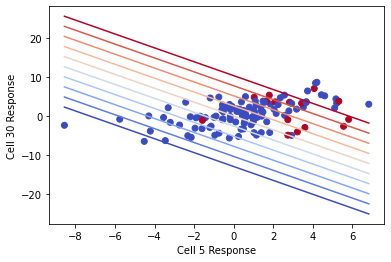

In [ ]:
# these randomly chosen cells are not bad, maybe actually better than the above?
cells_plot = [5, 30]
# Get the responses of the selected cells

# TODO: maybe change dataframe to int vs string columns?
cell1_responses = selected_responses.loc[:, str(cells_plot[0])]
cell2_responses = selected_responses.loc[:, str(cells_plot[1])]
plt.scatter(cell1_responses, cell2_responses, c=y, cmap='coolwarm')

# Add a line showing the dividing line from the parameters of the classifier
coef = model.coef_[0]

x_line = np.linspace(cell1_responses.min(), cell1_responses.max(), 100)

n = 10  # number of colors
# Get coolwarm colormap
cmap = plt.cm.coolwarm
# Generate a list of n colors from cool to warm
colors = [cmap(i) for i in np.linspace(0, 1, n)]

for i in range(n):
    y_line = ((i-n/2)/20 - coef[cells_plot[0]] * x_line) / coef[cells[1]]
    plt.plot(x_line, y_line, color=colors[i])

# Set the labels and title
plt.xlabel(f'Cell {cells_plot[0]} Response')
plt.ylabel(f'Cell {cells_plot[1]} Response')

# Show the plot
plt.show()

What if we trained on only these two cells - would the model better reflect our intution for their responses?

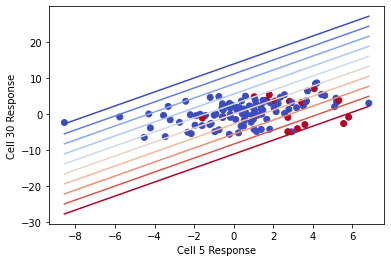

In [23]:
# these randomly chosen cells are not bad, maybe actually better than the above?
cells_plot = [5, 30]
# Get the responses of the selected cells

model2 = LogisticRegression()
model2.fit(X_train.loc[:, [str(x) for x in cells_plot]], y_train)
coef = model.coef_[0]

plt.scatter(cell1_responses, cell2_responses, c=y, cmap='coolwarm')
for i in range(n):
    y_line = ((i-n/2)/20 - coef[0] * x_line) / coef[1]
    plt.plot(x_line, y_line, color=colors[i])

# Set the labels and title
plt.xlabel(f'Cell {cells_plot[0]} Response')
plt.ylabel(f'Cell {cells_plot[1]} Response')

# Show the plot
plt.show()